# CNN Cancer Detection Kaggle Mini-Project
*** 
In this analysis, I'll be participating in the Histopathologic Cancer Detection challenge, which is a binary image classification task found on Kaggle. The objective of this challenge is to create a machine learning model that can accurately identify the presence of metastic cancer from small sections from histopathologic scans of lymph node sections. The key challenge is in distinguishing between normal and cancerous tissue within these images.

In [5]:
import pandas as pd

submission_sample = pd.read_csv('sample_submission.csv')
train_labels = pd.read_csv('train_labels.csv')

I've imported pandas which will be vital for this analysis along with importing both the train_labels and sample_submission .csv files, which will be used for this analysis.

When it comes to describing the challenge problem and NLP, the challenge problem as described earlier, is in classifying between normal and cancerous tissue within the images given. The size and dimension of the images are derived from larger digital pathology scans that have been translated to a uniform size. With the structure of the data, there's a training set and a test set. The training set contains images that provide the ground truth labels for each image. It uses binary classification with a 1 indicating the presence of at least one pixel of tumor tissue, or a 0 indicating no tumor tissue presence. The test set consists of images that the model will classify, with the results ultimately being submitted to Kaggle to assess the performance of my analysis.

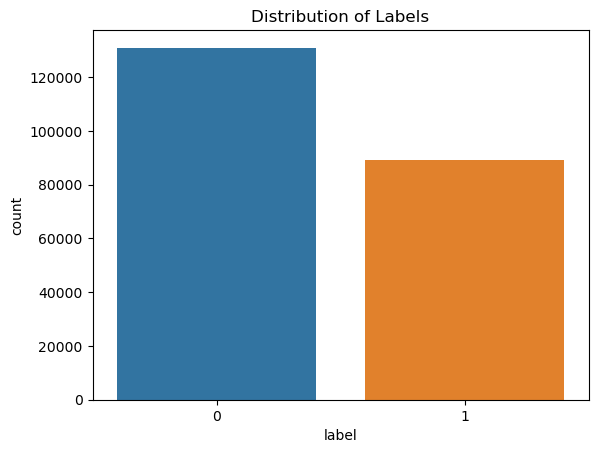

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_labels = pd.read_csv('train_labels.csv')

sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.show()

In [11]:
label_counts = train_labels['label'].value_counts()

label_counts

0    130908
1     89117
Name: label, dtype: int64

As we can see from the graph and the output of the exact number of 1's and 0's for the images, there's a fair bit of a difference with there being 130,908 0's and 89,117 1's. So this means there are 130,908 instances of there being tumor tissue and 89,117 instances with no tumor tissue

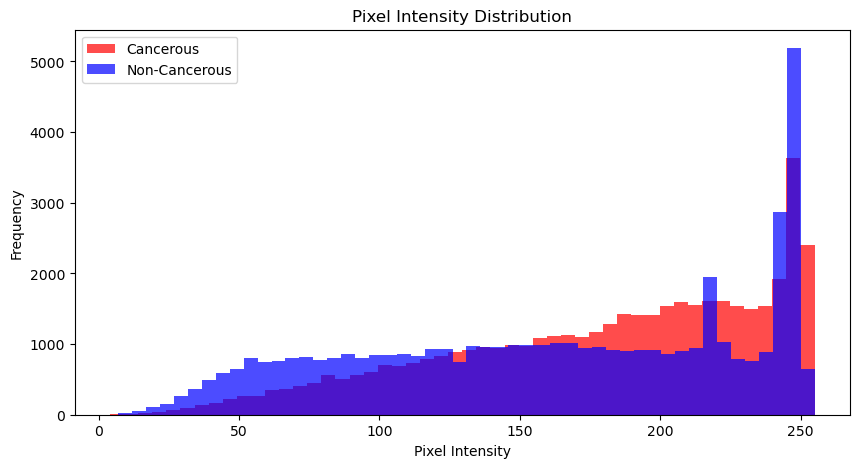

In [18]:
import numpy as np

def read_and_convert_to_grayscale(img_path):
    image = Image.open(img_path).convert('L') 
    return np.array(image).flatten()

positive_sample_paths = [os.path.join(path_to_images, f'{img_id}.tif') for img_id in sample_positive_ids]
negative_sample_paths = [os.path.join(path_to_images, f'{img_id}.tif') for img_id in sample_negative_ids]

positive_pixels = [read_and_convert_to_grayscale(img_path) for img_path in positive_sample_paths]
negative_pixels = [read_and_convert_to_grayscale(img_path) for img_path in negative_sample_paths]

positive_pixels = np.concatenate(positive_pixels)
negative_pixels = np.concatenate(negative_pixels)

plt.figure(figsize=(10, 5))
plt.hist(positive_pixels, bins=50, color='red', alpha=0.7, label='Cancerous')
plt.hist(negative_pixels, bins=50, color='blue', alpha=0.7, label='Non-Cancerous')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Above is a histogram showing pixel intensities between cancerous and non-cancerous images. Each bar represents the frequency of pixels within a particular intensity range. One way to look at this histogram for information is the height of the bars, which we see goes the highest with non-cancerous images. The height shows the frequency of that color which is represented on the x-axis that says "Pixel Intensity". This ranges from 0-255 for grayscale images, with 0 being the color black and 255 being white.

The width of the bars is also something to note which the wider a color is indicates more variation in that group of images. There's a significant amount of lower intensity ranges, which suggests that non-cancerous images have more darker regions. The red for cancerous images is in the higher intensity ranges, which means the cancerous images are lighter in color overall. We can see an overlap around the 125 range for pixel intensity, which means that for both cancerous and non-cancerous images there's similar pixel intensity values in these areas. 

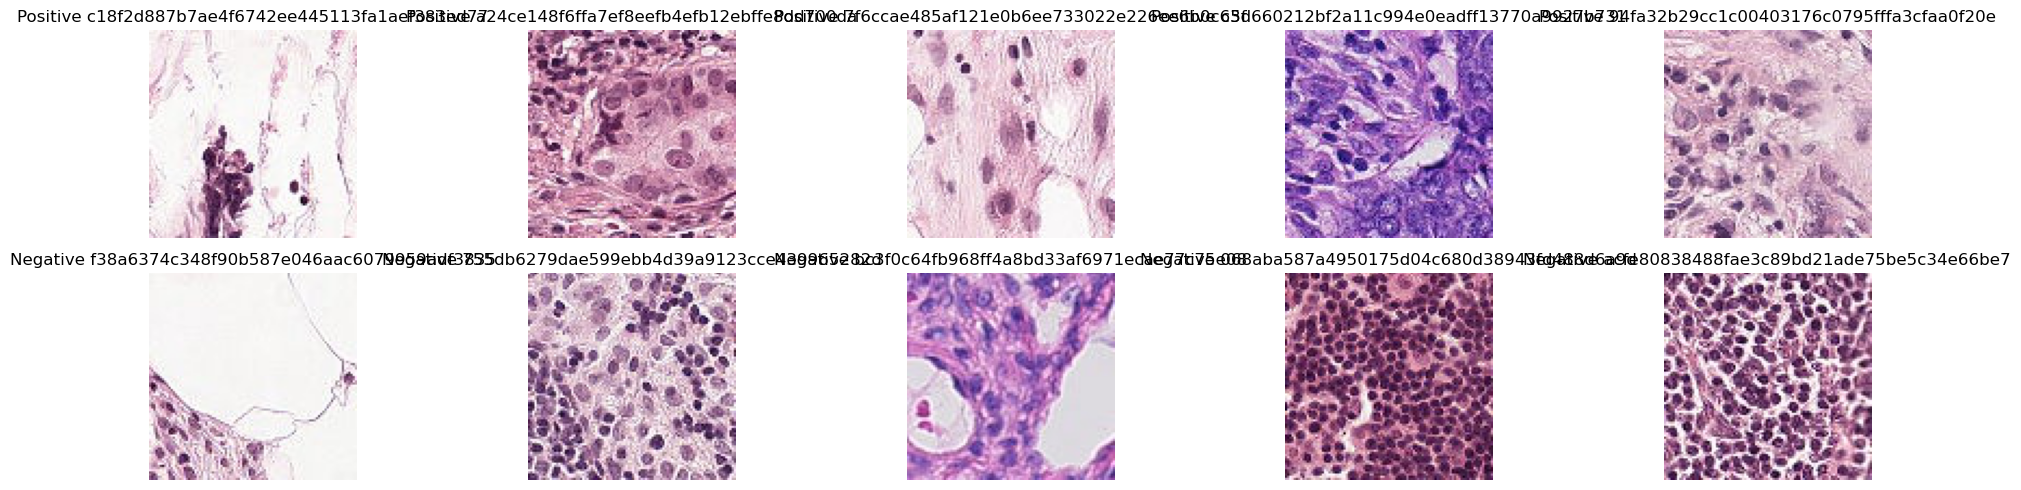

In [16]:
import matplotlib.pyplot as plt
import os
from PIL import Image

path_to_images = 'train/'

positive_ids = train_labels[train_labels['label'] == 1]['id'].values
negative_ids = train_labels[train_labels['label'] == 0]['id'].values

num_images = 5
sample_positive_ids = positive_ids[:num_images]
sample_negative_ids = negative_ids[:num_images]

fig, axs = plt.subplots(2, num_images, figsize=(20, 5))

for i, img_id in enumerate(sample_positive_ids):
    img_path = os.path.join(path_to_images, img_id + '.tif') 
    image = Image.open(img_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Positive {img_id}')

for i, img_id in enumerate(sample_negative_ids):
    img_path = os.path.join(path_to_images, img_id + '.tif')
    image = Image.open(img_path)
    axs[1, i].imshow(image)
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Negative {img_id}')

plt.tight_layout()
plt.show()

Here is a print out of five images that are positive for being cancerous, which is in the top row, and five images that are negative for being cancerous in the bottom row in the tissue samples. Some general observations that can be made are the density of the cells with the cancerous photos in the top row where they look to be packed together more compared to the non cancerous images in the bottom row where we see there's more spacing. There's also variation in cell size with the cancerous images in the top row when it comes to cell size and shape.

In [23]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_list = []

train_df = pd.read_csv('train_labels.csv')

for img_id in train_df['id']:
    img_path = f"{'train/'}/{img_id}.tif"  
    img = load_img(img_path, target_size=(96, 96))  
    img_array = img_to_array(img)
    image_list.append(img_array)

train_images = np.array(image_list)

datagen = ImageDataGenerator(
    rotation_range=90,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    rescale=1./255,           
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    vertical_flip=True       
)

datagen.fit(train_images)


So what I did above, as I'm sure anyone looking at this from the class can tell, is I did augmentation with the data. What this will do is let us understand how the model will perform with variations of the dataset. This will give me a good idea how versatile the model will be when it comes to overfitting and how well the model can generalize unseen data. Moving forward with my plan of analysis I want to see which features will be the best at predicting cancerous cells when it comes to shape, texture, color variation, etc. I want to create models that can learn these features and then move onto finding a strategy for splitting the dataset into training, validation, and test sets.

In [43]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import os

train_df = pd.read_csv('train_labels.csv')

downsampled_df = train_df.sample(n=10000, random_state=42)

image_dir = 'train/'
image_ids = downsampled_df['id'].values
images = []

for image_id in image_ids:
    img_path = os.path.join(image_dir, f'{image_id}.tif')
    img = load_img(img_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array /= 255.0
    images.append(img_array)

X = np.array(images)
y = downsampled_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model(learning_rate=1e-3):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_model, verbose=0)

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'learning_rate': [1e-2, 1e-3, 1e-4],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


C:\Users\14dav\AppData\Local\Temp\ipykernel_2632\1559334930.py:51: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=0)
c:\Users\14dav\miniconda3\envs\myenv\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.793249 using {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001}
0.612124 (0.006756) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01}
0.704502 (0.024396) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001}
0.793249 (0.010447) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001}
0.595002 (0.009791) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.01}
0.706124 (0.004807) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001}
0.777003 (0.018035) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0001}
0.599501 (0.011104) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.01}
0.713126 (0.009458) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001}
0.764499 (0.013813) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.0001}
0.599501 (0.011104) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01}
0.778376 (0.011226) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001}
0.786623 

In [45]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import os

train_df = pd.read_csv('train_labels.csv')

downsampled_df = train_df.sample(n=2500, random_state=42)

image_dir = 'train/'
image_ids = downsampled_df['id'].values
images = []

for image_id in image_ids:
    img_path = os.path.join(image_dir, f'{image_id}.tif')
    img = load_img(img_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array /= 255.0
    images.append(img_array)

X = np.array(images)
y = downsampled_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def build_model(learning_rate=1e-3):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_model, verbose=0)

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'learning_rate': [1e-2, 1e-3, 1e-4],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\14dav\AppData\Local\Temp\ipykernel_2632\2977858797.py:51: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=0)


Best: 0.794501 using {'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0001}
0.583498 (0.013149) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01}
0.742496 (0.005842) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001}
0.787503 (0.009914) with: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.0001}
0.582992 (0.020314) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.01}
0.756007 (0.010251) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001}
0.761489 (0.021013) with: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0001}
0.583498 (0.013149) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.01}
0.746501 (0.004155) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001}
0.763994 (0.008503) with: {'batch_size': 16, 'epochs': 30, 'learning_rate': 0.0001}
0.583498 (0.013149) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01}
0.763506 (0.009748) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001}
0.763995 

The CNN model I've used includes a sequence of convolutional layers with Conv2D that extracts features by convolving filters over the image. Each convolutional layer is followed by a MaxPooling2D layer that reduces spatial dimensions, capturing the most essential information. I also used dense and sigmoid layers for binary classification.

The reasoning for the model choice is that Convolutiuonal layers are good at learning image features, whereas max pooling reduces overfitting by providing an abstracted form of the representation. When comparing architectures, it seems that a model with few layers might possibly be better in my case. I say this because in part with the number of samples I used, I did two instances where one used 10,000 samples and the other, which is right above this, used 2,500. The hyperparameter that used 2,500 samples had a slightly higher accuracy than the one with 10,000, which the 2,500 sample had a peak accuracy of rougly 79.5%, whereas the 10,000 sample was just below that at roughly 79.3%. I tried running the full set of images initially, but after the code running for almost two and a half hours, it couldn't store anymore data and the whole thing was for nothing. I'm sure the accuracy would've been pretty high if I had an amazing computer, but for my first time doing anything like this, an accuracy of about 80% is good with me.

Hyperparameter tuning with GridSearchCV worked well to systemically navigate through the parameter space and find the best combination that resulted in the highest accuracy. The best parameter was with a learning rate of 0.0001, a batch size of 32, and 20 epochs, which is what got me the roughly 79.5% accuracy. Downsampling the dataset to 2,500 samples proved effective, although only a small improvement, without comprimising model accuracy. This might be because the larger dataset as a whole could have less informative samples, or the model would benefit from additional regularization techniques when training on more data. Like I had mentioned previously, I tried working with loading the entire dataset for model training and had a memory overload issue. I'm sure you probably wouldn't need a top tier computer to do this, but I wasn't sure exactly how. With this assignment, it feels like being thrown in the deep end and trying to stay afloat. 

   param_batch_size param_epochs param_learning_rate  mean_test_score  \
0                16           10                0.01         0.583498   
1                16           10               0.001         0.742496   
2                16           10              0.0001         0.787503   
3                16           20                0.01         0.582992   
4                16           20               0.001         0.756007   
5                16           20              0.0001         0.761489   
6                16           30                0.01         0.583498   
7                16           30               0.001         0.746501   
8                16           30              0.0001         0.763994   
9                32           10                0.01         0.583498   
10               32           10               0.001         0.763506   
11               32           10              0.0001         0.763995   
12               32           20                0.0

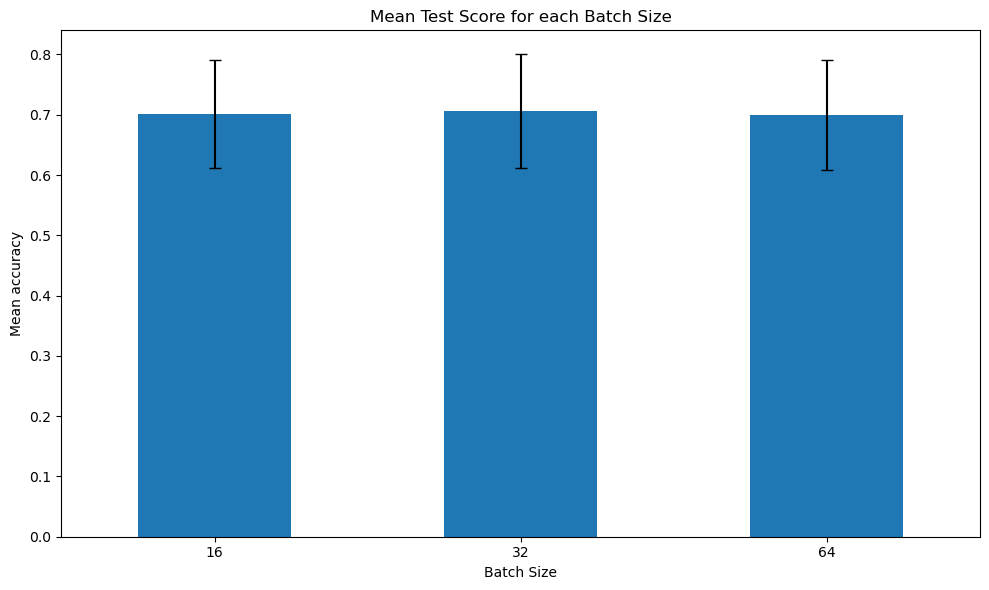

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_result.cv_results_)

table = results.loc[:, ['param_batch_size', 'param_epochs', 'param_learning_rate', 'mean_test_score', 'std_test_score']]
print(table)

mean_scores = results.groupby('param_batch_size').mean()['mean_test_score']
std_scores = results.groupby('param_batch_size').std()['mean_test_score']

plt.figure(figsize=(10, 6))
mean_scores.plot(kind='bar', yerr=std_scores, capsize=4)
plt.title('Mean Test Score for each Batch Size')
plt.ylabel('Mean accuracy')
plt.xlabel('Batch Size')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar chart above shows the mean accuracy of the various batch sizes used during model training. We have 16, 32, and 64 batch sizes, while the error bars suggest that the standard deviation of the accuracy across the various cross-validation folds. We can see that the mean accuracy for all three batches performed similarly. The model's performance is stable across the three batch sizes, which means changing the batch size doesn't produce any significant variation in results. Along with this, there doesn't appear to be a clear choice between the three since the mean accuracy is so similar. Batch size doesn't appear to be of importance in this case in terms of fine tuning the model.

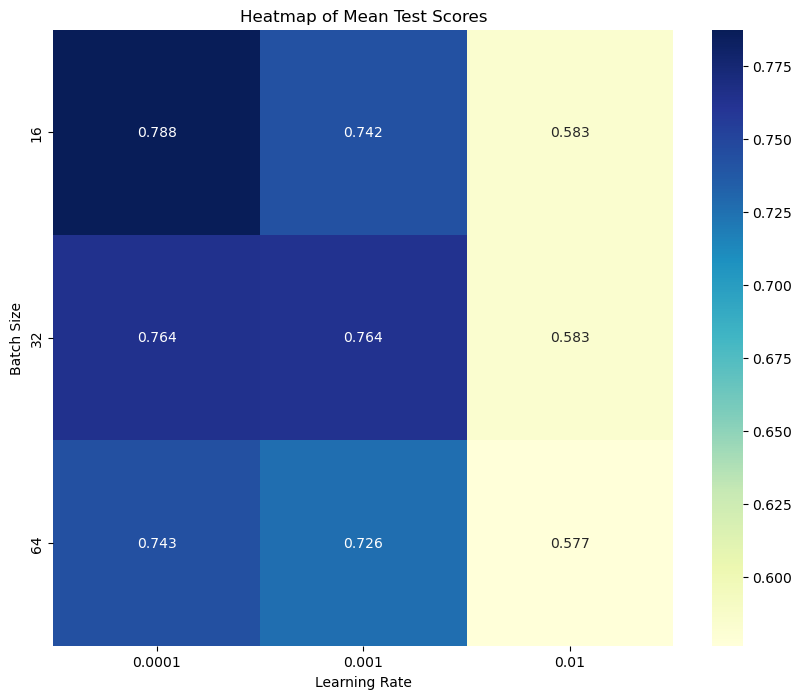

In [50]:
results = results.drop_duplicates(subset=['param_batch_size', 'param_learning_rate'])

pivot_table = results.pivot('param_batch_size', 'param_learning_rate', 'mean_test_score')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Heatmap of Mean Test Scores')
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.show()

The heatmap above is a visualization of the mean scores from the hyperparameter tuning with the different batch sizes on the y-axis and the learning rates on the x-axis. The darker the cell, the higher the accuracy, which in this case, is the dark blue shaded squares. The best results are clustered around the lower learning rates of 0.0001. This indicates a lower learning rate is best for the model and dataset.

Overall, I learned quite a bit with this assignment since I've never done anything in the neural network aspect of things. The hyperparameter tuning showed that a lower learning rate typically yielded a higher accuracy, batch size had little impact on the accuracy, and downsampling from 10,000 to 2,500 images for hyperparameter tuning slightly increased accuracy, but not by much. Improvements for the future would be using zooming, flipping, or even rotation techniques. Combining the predictions of multiple models to enhance predictave performance is another area that could improve things. Also a big thing I learned is not trying to process all of the images with this dataset at once because it turned out to be a waste of a little over two hours and ended up not yielding any results since the file size was too big.